# Import

In [87]:
import importlib
import data_loading   # your file, e.g. court_listener_cleaner.py
import api_call
importlib.reload(api_call)

<module 'api_call' from '/Users/ilyadavidson/Stanford_Internship/judge_project/api_call.py'>

In [1]:
import importlib, api_call
importlib.reload(api_call)
import pandas as pd
from data_loading import build_cap_dataset, court_listener_cleaner
from main import judges_promoted_from_district
from helper_functions import norm_id
from helper_functions import plot_distributions
from api_call import _extract_text
from api_call import load_case_results
import json
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from api_call import system_msg, developer_msg, user_template 
from api_call import _read_batch_jsonl

ModuleNotFoundError: No module named 'api_call'

In [2]:
import pandas as pd

In [3]:
df = pd.read_parquet("data/artifacts/cap/cap_dataset.parquet")

In [14]:
judges = pd.read_csv('data/judge_info.csv')

In [18]:
judges[judges['last name']=='weber']['court name'].iloc[0]

'United States District Court for the Western District of Pennsylvania'

In [19]:
df.sample(1)

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,...,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate,applt_uid,district_uid,district judge,district judge id
10434,"UNITED STATES of America, Plaintiff-Appellee, ...","Nos. 01-2060, 02-2067 and 02-2090",2003-09-29,United States Court of Appeals for the Fourth ...,U.S.,345 Federal Reporter 3d Series 262,"318 United States Reports 133, 1995 WL 478635,...","Before WIDENER, NIEMEYER, and LUTTIG, Circuit ...","[widener, niemeyer, luttig]","[2574, 1766, 1443]",...,"NIEMEYER, Circuit Judge.",niemeyer,1766.0,"Affirmed in part, reversed in part and remande...",56270,1,56270,17457,freedman,794.0


In [23]:
df.iloc[10434]['opinion_text']

'Affirmed in part, reversed in part and remanded by published opinion. Judge NIEMEYER wrote the opinion, in which Judge WIDENER joined. Judge LUTTIG wrote an opinion concurring in part and concurring in the judgment in part.\nOPINION\nNIEMEYER, Circuit Judge.\nFollowing the conviction of Charles McHan, Sr. for drug-trafficking and related offenses, the district court determined, pursuant to 21 U.S.C. § 853(a), that McHan was required to forfeit to the United States approximately $1.5 million in proceeds obtained as a result of his criminal conduct. When McHan could not account for the whereabouts of these proceeds, the court entered, as part of McHan’s sentence, a preliminary order forfeiting “substitute property” of McHan in the form of real estate and other assets, pursuant to 21 U.S.C. § 853(p).\nMcHan’s wife, Martha, and his two sons, John and Charles Jr., (the petitioners herein) filed a petition in Charles McHan, Sr.’s sentencing proceedings pursuant to 21 U.S.C. § 853(n), assert

In [27]:
cl_data = df[1:3].copy()

In [33]:
df = pd.read_parquet("data/artifacts/cap/cap_dataset.parquet")

In [45]:
df.sample(1)

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,...,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate,applt_uid,district_uid,district judge,district judge id
4685,Raymond FIEDLER; Melissa and Charlotte Fiedler...,No. 79-1556,1980-10-10,United States Court of Appeals for the Fourth ...,U.S.,631 Federal Reporter 2d Series 1144,"620 Federal Reporter 2d Series 1159, 24 L.Ed.2...","Before HAYNSWORTH, Chief Judge, PHILLIPS , Sen...","[haynsworth, phillips, ervin]","[1008, 1879, 715]",...,"ERVIN, Circuit Judge.",ervin,715.0,"ERVIN, Circuit Judge.\nIn this appeal, Raymond...",47180,1,47180,17376,lewis,1392.0


In [46]:
df[df['unique_id']=='47180']['opinion_text'].iloc[0]

'ERVIN, Circuit Judge.\nIn this appeal, Raymond Fiedler and his daughters, Melissa (Lisa) and Charlotte, all of whom are members of the white race, challenge the district court’s dismissal of their civil rights suit brought under 42 U.S.C. § 1981 against Marumsco Christian School, Marumsco Baptist Church (hereafter collectively called Marumsco) and Aleck Lee Bledsoe, principal of the school and pastor of the church (hereafter, Bledsoe). Alleging in district court that Lisa and Charlotte were expelled from the school in violation of their right to contract free from racial discrimination, the Fiedlers sought declaratory and injunctive relief and monetary damages; they also requested a jury trial.\nUpon commencement of the district court proceedings, counsel for Marumsco advised the court that Marumsco had filed petitions under the Bankruptcy Act earlier that morning, and requested a stay of the instant proceedings pending the outcome of the bankruptcy action. Denying the motion to stay 

# Data Collection

In [3]:
# promoted        = pd.read_csv('results/promoted_judge_stats.csv')
judges          = pd.read_csv('data/judge_info.csv')
with open("results/appellate_matches.json", "r", encoding="utf-8") as f:
    app_matches = json.load(f)   
df = build_cap_dataset()
# cl_cleaned = pd.read_csv('third_circuit_on_appeal.csv')
cl = pd.read_csv('third_circuit_on_appeal.csv')
cl = cl[cl['docket_number'].notna()] # remove nas
cl = cl.drop_duplicates(subset="docket_number", keep="first") # drop dupes

Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


In [10]:
df = df[df['is_appellate']==1]

In [12]:
df = df.drop_duplicates(subset="docket_number", keep="first") # drop dupes

In [13]:
cl_dockets = cl["docket_number"].dropna().astype(str).unique().tolist()
cap_dockets = df["docket_number"].dropna().astype(str).unique().tolist()

def has_overlap(cl_docket: str, cap_dockets=cap_dockets) -> bool:
    for cap_d in cap_dockets:
        if cl_docket in cap_d or cap_d in cl_docket:
            return True
    return False

cl["overlap_by_substring"] = cl["docket_number"].astype(str).apply(has_overlap)

total = len(cl)
overlap = cl["overlap_by_substring"].sum()
non_overlap = total - overlap

print(f"Total CourtListener cases: {total}")
print(f"Overlap by substring with CAP: {overlap}")
print(f"No overlap with CAP: {non_overlap}")

Total CourtListener cases: 2705
Overlap by substring with CAP: 1912
No overlap with CAP: 793


In [11]:
overlap = cl[cl['overlap_by_substring']==False]

In [12]:
overlap

,cluster_id,case_name,docket_number,combined_preview,overlap_by_substring
0,10679495,United States v. Natalya Shvets,22-2683,PRECEDENTIAL\n\n UNITED STATES COURT OF A...,False
1,10678447,Bobrick Washroom Equipment Inc v. Scranton Pro...,23-2577,PRECEDENTIAL\n\n UNITED STATES COURT OF...,False
2,10675432,Robert Sofaly v. Portfolio Recovery Associates...,24-2639,PRECEDENTIAL\n\n UNITED STATES COURT OF APP...,False
3,10674376,United States v. Xavier Josey,24-1891,PRECEDENTIAL\n\n UNITED STATES COURT O...,False
4,10673697,United States v. Ben McCormack,24-2500,PRECEDENTIAL\n\n UNITED STATES COURT OF ...,False
...,...,...,...,...,...
2997,252526,"LYNCHBURG GAS COMPANY, Petitioner, v. FEDERAL ...",13285_1,"McLAUGHLIN, Circuit Judge. Petitioner, Lynchbu...",False
3010,226718,In Re DISTILLERS FACTORS CORP.,10274_1,"HASTIE, Circuit Judge. This appeal is from an ...",False
3012,228399,GULF RESEARCH & DEVELOPMENT CO. Et Al. v. LEAH...,10488_1,"*303 MARIS, Circuit Judge. This is a petition ...",False
3014,226291,In Re KELLETT AIRCRAFT CORP.,10207_1,"HASTIE, Circuit Judge. This case comes before ...",False


In [ ]:
cl_cleaned = court_listener_cleaner(cl, judges, "combined_preview", df, "docket_number", "unique_id") # 2705 cases go in and come out
cl_cleaned = cl_cleaned[cl_cleaned['judge id'].notna()] # 1323 cases had a judge name that could be matched to a judge id
cl_cleaned = cl_cleaned[cl_cleaned['unique_id'].notna()] # 1915 cases had a docket number that could be matched to CAP
cl_cleaned = cl_cleaned.drop_duplicates(subset="unique_id", keep="first") # we end up with 683 unique cases that have a judge id and docket number that matches CAP

In [10]:
len(cl_cleaned)

683

In [13]:
683 + 790

1473

In [16]:
len(df[df['is_appellate']==1])

51339

In [14]:
df[df['is_appellate']==1].sample(1)

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
56306,"UNITED STATES of America, Appellant, v. Cornel...",No. 14091,1964-04-10,United States Court of Appeals for the Third C...,U.S.,333 Federal Reporter 2d Series 100,"213 F.Supp. 905, 46 F.Supp. 484, 65 F.Supp. 41...",None,[],[],majority,"BIGGS, Chief Judge.",biggs,170.0,"BIGGS, Chief Judge.\nThe United States brought...",56306,1


In [15]:
appellate_ids = df[df['is_appellate'] == 1]['unique_id'].astype(str)
matched = appellate_ids.isin(app_matches.keys()).sum()
print(f"We were able to match {matched} out of {len(appellate_ids)} appellate cases ({matched/len(appellate_ids):.2%})")

We were able to match 5818 out of 51339 appellate cases (11.33%)


In [16]:
print(f"With the court listener data we have {len(cl_cleaned)+matched} appellate cases with outcomes.")

With the court listener data we have 6501 appellate cases with outcomes.


In [17]:
print(f"There are {len(judges['judge id'].unique())} total judges.") # total number of judges in dataset

aj = judges[judges['court type'].str.contains('Appeals|Circuit', case=False, na=False)]

print(f"There are {len(aj['judge id'].unique())} appellate judges") # unique appellate judges

dj = judges[judges['court type'].str.contains('District')]

print(f"There are {len(dj['judge id'].unique())} district judges") # unique district judges

There are 4026 total judges.
There are 882 appellate judges
There are 3277 district judges


In [17]:
def promotion_info_judges(judge_info):
    """
    Returns a df of all judges who got promoted from district to appellate courts. Their promotion date is the earliest nomination date that they got to the appellate court. 
    """
    ji = judge_info.copy()
    ji['promotion date'] = pd.NaT

    aj = ji[ji['court type'].str.contains('Appeals|Circuit', case=False, na=False)]
    dj = ji[ji['court type'].str.contains('District')]
    pj = dj[dj['judge id'].isin(aj['judge id'])].copy()
    pj['nomination date'] = pd.to_datetime(pj['nomination date'], errors='coerce')
    pj = pj.sort_values(['judge id','nomination date']).drop_duplicates('judge id', keep='first')

    ji['is promoted'] = ji['judge id'].isin(pj['judge id']).astype(int)
    ji['promotion date'] = ji.apply(lambda row: pj[pj['judge id']==row['judge id']]['nomination date'].values[0] if row['is promoted'] else pd.NaT, axis=1)
    ji_district = ji[ji['court type'].str.contains('District')]
    ji_district = ji_district.drop_duplicates('judge id', keep='first')
    return ji_district

In [18]:
dsct_jdges = promotion_info_judges(judges) # district judges with promotion info
len(dsct_jdges)

3277

In [19]:
dsct_jdges.sample(1)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career,promotion date,is promoted
3299,13761471,sherriff,Kirk,Male,White,1968,Berkeley,CA,NaN,NaN,...,54/45,2024-01-31,2024-02-07,Columbia University,B.A.,Harvard Law School,J.D.,"Private practice, New York City, 1995-1996, 19...",NaT,0


In [21]:
len(dsct_jdges[dsct_jdges['is promoted']==1]) / len(dsct_jdges) * 100 # proportion of district judges who got promoted

9.826060421116875

In [22]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)]) / len(dsct_jdges[dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")]) * 100 # proportion of district judges in the third court who got promoted

11.411411411411411

In [23]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)])

38

In [24]:
thrd_judges = dsct_jdges[dsct_jdges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

# Computation

In [92]:
api_path:       str = "batch_runs/api_responses.jsonl"
overlap_path:   str = "batch_runs/overlap_outputs/overlap_results.jsonl"

opinions_primary  = _read_batch_jsonl(api_path)
opinions_overlap  = _read_batch_jsonl(overlap_path)
opinions          = {**opinions_overlap, **opinions_primary}

In [ ]:
def compute_district_overturns(
    df:             pd.DataFrame,
    dsct_judges:    pd.DataFrame,
    api_path:       str = "batch_runs/api_responses.jsonl",
    mapping_path:   str = "results/appellate_matches.json",
    court_listener: pd.DataFrame = None,
    overlap_path:   str = "batch_runs/overlap_outputs/overlap_results.jsonl",
) -> pd.DataFrame:
    """
    Compute district-level overturn counts & rates per judge.

    Reads:
      - mapping_path: JSON mapping {appellate_custom_id -> district_unique_id}
      - api_path:     JSONL with batch responses (has custom_id + response)
      - overlap_path: (optional) another JSONL of the same schema to merge in

    Notes:
      * Responses from api_path and overlap_path are merged and de-duped by custom_id.
      * We only need the 'opinion' field parsed from the model text; 'affirmed' vs non-affirmed.

    :param df: DataFrame of all CAP cases (district + appellate)
    :param dsct_judges: DataFrame of district judges to compute stats for (must have 'judge id' and 'is promoted')
    """
    pj                     = dsct_judges.copy()
    dsc                    = df[df['is_appellate'] == 0].copy()
    dsc["_author_id_norm"] = dsc["opinion_author_id"].map(norm_id) # turns 5.0 -> 5

    by_judge_cases = (
        dsc
        .dropna(subset=["_author_id_norm"])
        .groupby("_author_id_norm")
        .apply(lambda g: list(g.index))
        .to_dict()
    ) # {judge_id: [list of district case indices]}

    pj["_judge_id_norm"]      = pj["judge id"].map(norm_id) # turns 5.0 -> 5
    pj["district_cases_list"] = pj["_judge_id_norm"].map(by_judge_cases).apply(lambda x: x if isinstance(x, list) else []) # list of case indices or empty list
    pj["district cases"]      = pj["district_cases_list"].str.len().astype(int) # count of district cases

    # Load the appellate -> district mapping
    try:
        with open(mapping_path, "r", encoding="utf-8") as f:
            app_to_dct = json.load(f)
    except FileNotFoundError:
        app_to_dct = {}

    # Load the API opinions
    opinions_primary  = _read_batch_jsonl(api_path)
    opinions_overlap  = _read_batch_jsonl(overlap_path)
    opinions          = {**opinions_overlap, **opinions_primary} # ^ merge strategy: keep 'opinions_primary' preference on conflict (last write wins). There shouldn't be conflicts anyway.

    # ----- Build overturned district index set using mapping + opinions -----
    overturned_district_indices: set[int] = set()
    for cid, opinion in opinions.items():
        if opinion and opinion != "affirmed":
            if cid in app_to_dct:
                try:
                    overturned_district_indices.add(int(app_to_dct[cid]))
                except Exception:
                    pass

    # Appeals coverage count (mapping-based)
    appealed_district_cases = set(app_to_dct.values())
    pj["appealed cases"] = pj["district_cases_list"].apply(
        lambda case_list: sum(1 for cid in case_list if cid in appealed_district_cases)
    ).astype(int)

    # ===== CourtListener: add tallies to district & appealed (no extra column) =====
    if court_listener is not None and not court_listener.empty:
        cl = court_listener.copy()
        cl["judge id"] = pd.to_numeric(cl["judge id"], errors="coerce").astype("Int64")
        cl = cl.dropna(subset=["judge id", "docket_number"])
        cl["docket_number"] = cl["docket_number"].astype(str)

        cl_counts = (
            cl.groupby("judge id")["docket_number"]
              .nunique()
              .astype(int)
        )

        add_series = pj["judge id"].map(cl_counts).fillna(0).astype(int)
        pj["district cases"] = (pj["district cases"] + add_series).astype(int)
        pj["appealed cases"] = (pj["appealed cases"] + add_series).astype(int)

    # ----- Overturned (mapping-only baseline) -----
    def _count_overturned(case_list):
        if not case_list:
            return 0
        return sum(1 for cid in case_list if cid in overturned_district_indices)

    pj["overturned_from_mapping"] = pj["district_cases_list"].apply(_count_overturned).astype(int)

    # ----- CourtListener overlap augmentation (overturned) -----
    extra_overturned_by_judge: dict[int, int] = {}

    if court_listener is not None and not court_listener.empty:
        cl2 = court_listener.dropna(subset=["docket_number"]).copy()
        cl2["judge id"] = pd.to_numeric(cl2["judge id"], errors="coerce").astype("Int64")
        cl2 = cl2.dropna(subset=["judge id"])
        cl_dockets = cl2["docket_number"].astype(str).dropna().unique().tolist()

        def has_overlap(docket: str) -> bool:
            if not isinstance(docket, str):
                return False
            return any(docket in cl_d or cl_d in docket for cl_d in cl_dockets)

        df_local = df.copy()
        df_local["__has_docket"] = df_local["docket_number"].notna()
        df_local["overlap"] = False
        mask = df_local["__has_docket"]
        df_local.loc[mask, "overlap"] = df_local.loc[mask, "docket_number"].astype(str).apply(has_overlap)

        overlap_cases = df_local[df_local["overlap"] & df_local["unique_id"].notna()].copy()
        overlap_cases["unique_id"] = overlap_cases["unique_id"].astype(str)

        cl_rows = cl2[["docket_number", "judge id"]].copy()
        cl_rows["docket_number"] = cl_rows["docket_number"].astype(str)

        # Use merged 'opinions' (primary + overlap) for non-affirmed check
        for df_docket, block in overlap_cases.groupby("docket_number"):
            df_docket = str(df_docket)
            cl_judges = set(
                int(j) for d, j in zip(cl_rows["docket_number"], cl_rows["judge id"])
                if (df_docket in d) or (d in df_docket)
            )
            if not cl_judges:
                continue

            uids_here = set(block["unique_id"].astype(str).unique())
            non_aff = [u for u in uids_here if (opinions.get(u, "").lower() not in ("", "affirmed"))]
            if not non_aff:
                continue

            for jid in cl_judges:
                extra_overturned_by_judge[jid] = extra_overturned_by_judge.get(jid, 0) + 1

    def _cl_extra_for_row(row) -> int:
        jid = row.get("judge id")
        if pd.isna(jid):
            return 0
        return int(extra_overturned_by_judge.get(int(jid), 0))

    pj["overturned_from_cl"] = pj.apply(_cl_extra_for_row, axis=1).astype(int)

    # ----- Combine + rates -----
    pj["district_cases_overturned"] = pj["overturned_from_mapping"] + pj["overturned_from_cl"]
    pj["district_overturn_rate"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["district cases"]) if r["district cases"] else pd.NA,
        axis=1
    )
    pj["overturn_rate_among_appeals"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["appealed cases"]) if r["appealed cases"] else pd.NA,
        axis=1
    )

    pj.drop(columns=["_judge_id_norm"], inplace=True)

    # dtypes
    pj["judge id"]                  = pd.to_numeric(pj["judge id"], errors="coerce").astype("Int64")
    pj["district cases"]            = pd.to_numeric(pj["district cases"], errors="coerce").astype(int)
    pj["appealed cases"]            = pd.to_numeric(pj["appealed cases"], errors="coerce").astype(int)
    pj["overturned_from_mapping"]   = pd.to_numeric(pj["overturned_from_mapping"], errors="coerce").astype(int)
    pj["overturned_from_cl"]        = pd.to_numeric(pj["overturned_from_cl"], errors="coerce").astype(int)
    pj["district_cases_overturned"] = pd.to_numeric(pj["district_cases_overturned"], errors="coerce").astype(int)

    return pj

In [98]:
import json
import pandas as pd
from typing import Dict, Optional

def compute_district_overturns(
    df:             pd.DataFrame,                          # CAP cases (district + appellate)
    dsct_judges:    pd.DataFrame,                          # must include 'judge id' and any judge metadata
    api_path:       str = "batch_runs/api_responses.jsonl",
    mapping_path:   str = "results/appellate_matches.json",
    court_listener: Optional[pd.DataFrame] = None,         # one CL dataset: each row = an appealed case for that CL judge
    overlap_path:   str = "batch_runs/overlap_outputs/overlap_results.jsonl",
    add_cl_to_district_totals: bool = False,               # set True to also add CL docket counts to 'district cases'
) -> pd.DataFrame:
    """
    Compute judge-level counts and rates:
      - district cases (from CAP)
      - appealed cases (CAP mapping + CourtListener rows)
      - overturned_from_mapping (CAP mapping + API opinions)
      - overturned_from_cl (CourtListener rows using merged opinions by unique_id, or CL's own 'opinion' text)
      - district_cases_overturned = mapping + CL
      - district_overturn_rate = overturned / district cases
      - overturn_rate_among_appeals = overturned / appealed cases

    Assumptions:
      - mapping_path: {appellate_custom_id (str) -> district_unique_id (int/str that identifies the district case in df)}
      - api_path, overlap_path: JSONL lines with fields including {"custom_id": "...", "response": ...} where
        `_extract_text(response)` returns a JSON string containing an "opinion" field (e.g., "affirmed", "reversed", etc.)
      - court_listener rows optionally include 'unique_id' (appellate custom_id or aligned id) and/or an 'opinion' text column
      - A CL row is an appealed case for its 'judge id' regardless of mapping back to CAP.

    Set add_cl_to_district_totals=True if you want CL to also inflate 'district cases' (previous behavior).
    """

    # --------------------------- Small helpers ---------------------------
    def norm_id(x):
        if pd.isna(x):
            return None
        s = str(x).strip()
        if s.endswith(".0"):
            s = s[:-2]
        try:
            s = str(int(float(s)))
        except Exception:
            pass
        return s

    def _read_batch_jsonl(path: str) -> Dict[str, str]:
        """Return {custom_id -> opinion(lower)} from a JSONL results file."""
        out: Dict[str, str] = {}
        if not path:
            return out
        try:
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    if not line.strip():
                        continue
                    try:
                        rec = json.loads(line)
                    except Exception:
                        continue
                    if rec.get("error"):
                        continue
                    txt = _extract_text(rec.get("response", {}))
                    if not txt:
                        continue
                    try:
                        obj = json.loads(txt)
                    except json.JSONDecodeError:
                        continue
                    op  = (obj.get("opinion") or "").strip().lower()
                    cid = str(rec.get("custom_id") or "")
                    if cid and op:
                        # keep first seen for stability; later merge resolves precedence
                        out.setdefault(cid, op)
        except FileNotFoundError:
            pass
        return out

    # --------------------------- Build per-judge CAP district universe ---------------------------
    pj = dsct_judges.copy()

    dsc = df[df["is_appellate"] == 0].copy()
    dsc["_author_id_norm"] = dsc["opinion_author_id"].map(norm_id)

    by_judge_cases = (
        dsc.dropna(subset=["_author_id_norm"])
           .groupby("_author_id_norm")
           .apply(lambda g: list(g.index))
           .to_dict()
    )
    pj["_judge_id_norm"]      = pj["judge id"].map(norm_id)
    pj["district_cases_list"] = pj["_judge_id_norm"].map(by_judge_cases).apply(lambda x: x if isinstance(x, list) else [])
    pj["district cases"]      = pj["district_cases_list"].str.len().astype(int)

    # --------------------------- Load mapping (appellate custom_id -> district unique_id) ---------------------------
    try:
        with open(mapping_path, "r", encoding="utf-8") as f:
            app_to_dct = json.load(f)
    except FileNotFoundError:
        app_to_dct = {}

    # --------------------------- Load & merge model opinions ---------------------------
    opinions_primary = _read_batch_jsonl(api_path)
    opinions_overlap = _read_batch_jsonl(overlap_path)
    # prefer primary on conflicts
    opinions = {**opinions_overlap, **opinions_primary}

    # --------------------------- Overturned via CAP mapping + opinions ---------------------------
    overturned_district_indices: set = set()
    for cid, op in opinions.items():
        if op and op != "affirmed":
            if cid in app_to_dct:
                try:
                    overturned_district_indices.add(int(app_to_dct[cid]))
                except Exception:
                    # tolerate non-int district ids
                    overturned_district_indices.add(str(app_to_dct[cid]))

    appealed_district_cases = set(app_to_dct.values())
    pj["appealed cases"] = pj["district_cases_list"].apply(
        lambda lst: sum(1 for cid in lst if cid in appealed_district_cases)
    ).astype(int)

    def _count_overturned(case_list):
        if not case_list:
            return 0
        return sum(1 for cid in case_list if cid in overturned_district_indices)

    pj["overturned_from_mapping"] = pj["district_cases_list"].apply(_count_overturned).astype(int)

    # --------------------------- CourtListener as its own appealed cases ---------------------------
    # Each CL row = 1 appealed case for that CL judge. Opinion comes from:
    #  (1) merged opinions[unique_id] if unique_id exists; else
    #  (2) CL's own 'opinion' text if present.
    pj["overturned_from_cl"] = 0  # initialize if not present

    if court_listener is not None and not court_listener.empty:
        cl = court_listener.copy()

        # normalize judge id
        cl["judge id"] = pd.to_numeric(cl.get("judge id", pd.Series(dtype="float")), errors="coerce").astype("Int64")
        cl = cl.dropna(subset=["judge id"])
        cl["judge id"] = cl["judge id"].astype("Int64")

        # opinion resolution per row
        uid = cl.get("unique_id", pd.Series([pd.NA]*len(cl))).astype(str)
        cl_opinion_fallback = cl.get("opinion", pd.Series([""]*len(cl))).astype(str)

        def resolve_opinion(i):
            u = uid.iat[i]
            if isinstance(u, str) and len(u) > 0:
                op = opinions.get(u, "")
                if op:
                    return op
            fb = cl_opinion_fallback.iat[i]
            return fb.strip().lower() if fb else ""

        cl["opinion_norm_cl"] = [resolve_opinion(i) for i in range(len(cl))]

        # +1 appealed for every CL row
        appealed_add_cl = cl.groupby("judge id").size().astype(int)

        # +1 overturned_from_cl for opinion != 'affirmed'
        non_aff_mask = (cl["opinion_norm_cl"] != "") & (cl["opinion_norm_cl"] != "affirmed")
        if non_aff_mask.any():
            overturned_add_cl = cl.loc[non_aff_mask].groupby("judge id").size().astype(int)
        else:
            overturned_add_cl = pd.Series(dtype=int)

        # apply to pj
        pj["appealed cases"] = (
            pj["appealed cases"] + pj["judge id"].map(appealed_add_cl).fillna(0).astype(int)
        ).astype(int)

        pj["overturned_from_cl"] = (
            pj["overturned_from_cl"] + pj["judge id"].map(overturned_add_cl).fillna(0).astype(int)
        ).astype(int)

        # OPTIONAL: also add CL dockets to 'district cases' (prev behavior)
        if add_cl_to_district_totals and ("docket_number" in cl.columns):
            cl["docket_number"] = cl["docket_number"].astype(str)
            cl_counts = cl.groupby("judge id")["docket_number"].nunique().astype(int)
            pj["district cases"] = (pj["district cases"] + pj["judge id"].map(cl_counts).fillna(0).astype(int)).astype(int)

    # --------------------------- Combine & rates ---------------------------
    pj["district_cases_overturned"] = pj["overturned_from_mapping"] + pj["overturned_from_cl"]

    pj["district_overturn_rate"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["district cases"]) if r["district cases"] else pd.NA,
        axis=1
    )
    pj["overturn_rate_among_appeals"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["appealed cases"]) if r["appealed cases"] else pd.NA,
        axis=1
    )

    # tidy types and drop helper
    pj.drop(columns=["_judge_id_norm"], inplace=True)
    pj["judge id"]                  = pd.to_numeric(pj["judge id"], errors="coerce").astype("Int64")
    pj["district cases"]            = pd.to_numeric(pj["district cases"], errors="coerce").astype(int)
    pj["appealed cases"]            = pd.to_numeric(pj["appealed cases"], errors="coerce").astype(int)
    pj["overturned_from_mapping"]   = pd.to_numeric(pj["overturned_from_mapping"], errors="coerce").astype(int)
    pj["overturned_from_cl"]        = pd.to_numeric(pj["overturned_from_cl"], errors="coerce").astype(int)
    pj["district_cases_overturned"] = pd.to_numeric(pj["district_cases_overturned"], errors="coerce").astype(int)

    return pj

In [99]:
overturns = compute_district_overturns(df, thrd_judges, court_listener=cl_cleaned)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_77916/1765006753.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g.index))


In [127]:
len(thrd_judges) 
len(overturns[overturns['district cases']>0])

279

# Inference

In [101]:
bt10 = overturns[overturns['appealed cases']>=10]

In [102]:
bt10.sample(3)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
1881,2735,kauffman,Bruce,Male,White,1934,Atlantic City,NJ,2021.0,Bala Cynwyd,...,NaT,0,"[4838, 5500, 36210, 36254, 36575, 36635, 36665...",41,10,2,4,6,0.146341,0.6
2204,1440,luongo,Alfred,Male,White,1920,Philadelphia,PA,1986.0,,...,NaT,0,"[570, 1063, 1182, 1265, 16962, 17001, 17013, 1...",508,49,19,0,19,0.037402,0.387755
886,577,davis,John,Male,White,1906,Shenandoah,PA,1984.0,,...,NaT,0,"[189, 17998, 18047, 18081, 18111, 18119, 18139...",171,18,7,0,7,0.040936,0.388889


In [103]:
len(bt10[bt10['is promoted']==1]) / len(bt10) * 100 # proportion of district judges with at least 10 appealed cases who got promoted

11.976047904191617

We have a little bit more data of cases on the judges who did not get promoted (+- 10% more cases on average)

In [104]:
bt10.groupby("is promoted")["district cases"].mean()

is promoted
0    229.938776
1    212.650000
Name: district cases, dtype: float64

In [105]:
bt10.groupby("is promoted")["overturn_rate_among_appeals"].mean()

is promoted
0     0.44474
1    0.362871
Name: overturn_rate_among_appeals, dtype: object

In [106]:
promoted_mean = bt10[bt10["is promoted"] == 1]["overturn_rate_among_appeals"].mean()
not_promoted_mean = bt10[bt10["is promoted"] == 0]["overturn_rate_among_appeals"].mean()
effect = promoted_mean - not_promoted_mean
print("Average effect of being promoted:", effect)

Average effect of being promoted: -0.08186940077508231


In [132]:
bt10.sample(1)['party of appointing president']

416    Republican
Name: party of appointing president, dtype: object

In [140]:
df.columns

Index(['name', 'docket_number', 'decision_date', 'court_name', 'jurisdiction',
       'cite', 'cites_to', 'judges_raw', 'judges_clean', 'judges_ids',
       'opinion_type', 'opinion_author_raw', 'opinion_author_clean',
       'opinion_author_id', 'opinion_text', 'unique_id', 'is_appellate'],
      dtype='object')

In [139]:
judges.columns

Index(['judge id', 'last name', 'first name', 'gender', 'ethnicity',
       'birth year', 'birth city', 'birth state', 'death year', 'death city',
       'death state', 'court name', 'court type', 'appointment title',
       'appointing president', 'party of appointing president',
       'nomination date', 'termination date', 'termination', 'aba rating',
       'hearing date', 'judiciary committee action', 'committee action date',
       'senate vote type', 'ayes/nays', 'confirmation date', 'commission date',
       'school 1', 'degree 1', 'school 2', 'degree 2', 'professional career'],
      dtype='object')

In [138]:
# Regression analysis with gender and ethnicity
y = bt10["is promoted"].astype(float)  
X = pd.DataFrame({
    "overturn_rate_among_appeals": pd.to_numeric(bt10["overturn_rate_among_appeals"], errors="coerce"),
    "gender": bt10["gender"].fillna("Unknown").astype("category"),
    "ethnicity": bt10["ethnicity"].fillna("Unknown").astype("category"),
    "aba rating": bt10["aba rating"].fillna("Unknown").astype("category"),
    "party of appointing president": bt10["party of appointing president"].fillna("Unknown").astype("category"),
})

X = pd.get_dummies(X, columns=["gender", "ethnicity", "aba rating", "party of appointing president"], drop_first=True, dtype=float)

mask = ~(y.isna() | X.isna().any(axis=1))
y_clean = y.loc[mask]
X_clean = X.loc[mask]

X_clean = sm.add_constant(X_clean, has_constant="add")

logit_model = sm.Logit(y_clean, X_clean).fit(maxiter=100)
print("=== Logistic Regression: is promoted ~ overturn_rate_among_appeals + gender + ethnicity ===")
print(logit_model.summary())

ols_model = sm.OLS(y_clean, X_clean).fit(maxiter=100)
print("\n=== OLS Regression: is promoted ~ overturn_rate_among_appeals + gender + ethnicity ===")
print(ols_model.summary())

         Current function value: 0.336083
         Iterations: 100
=== Logistic Regression: is promoted ~ overturn_rate_among_appeals + gender + ethnicity ===
                           Logit Regression Results                           
Dep. Variable:            is promoted   No. Observations:                  167
Model:                          Logit   Df Residuals:                      158
Method:                           MLE   Df Model:                            8
Date:                Mon, 06 Oct 2025   Pseudo R-squ.:                 0.08286
Time:                        09:12:55   Log-Likelihood:                -56.126
converged:                      False   LL-Null:                       -61.197
Covariance Type:            nonrobust   LLR p-value:                    0.2552
                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

/Users/ilyadavidson/Stanford_Internship/judge_project/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [110]:
# Simple regression analysis
y = bt10["is promoted"].astype(int)
X = bt10["overturn_rate_among_appeals"].astype(float)
X = sm.add_constant(X) 

logit_model = sm.Logit(y, X).fit()
mfx_ame = logit_model.get_margeff(at='overall', method='dydx')  # AME
ols_model = sm.OLS(y, X).fit()

print(logit_model.summary())
print(mfx_ame.summary())
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.349861
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            is promoted   No. Observations:                  167
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Oct 2025   Pseudo R-squ.:                 0.04526
Time:                        17:48:15   Log-Likelihood:                -58.427
converged:                       True   LL-Null:                       -61.197
Covariance Type:            nonrobust   LLR p-value:                   0.01859
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.3660      0.723     -0.506      0.613   

For OLS: For a 1.0 (100 percentage-point) increase in overturn_rate_among_appeals, the predicted probability of being promoted decreases by 0.4155 (≈ 41.6 percentage points).
Say a judge’s overturn rate goes from: 0.2 → 0.3 (a 10 percentage-point increase). Then the predicted probability of promotion changes by:
ΔP = -0.4155 * (0.3 - 0.2) = -0.04155. That’s about a 4.2 percentage-point drop in the probability of promotion.

This model however can predict probabilities below 0 or above 1. The logistic regression is often preferred for binary outcomes because it constrains probabilities between 0–1 and models odds nonlinearly.

For the logit with the marginal effects one, on average, across all judges, a 1.0 (100 percentage-point) increase in overturn rate lowers the probability of promotion by 0.4675, or about 47 percentage points.


In [60]:
bt10["high_overturn"] = (bt10["overturn_rate_among_appeals"] >  0.5).astype(int) # the average
X = bt10["is promoted"].astype(float)
X = sm.add_constant(X)  # add intercept
y = bt10["high_overturn"]

# Logistic regression
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.595694
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          high_overturn   No. Observations:                  167
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Oct 2025   Pseudo R-squ.:                 0.04669
Time:                        17:24:28   Log-Likelihood:                -99.481
converged:                       True   LL-Null:                       -104.35
Covariance Type:            nonrobust   LLR p-value:                  0.001799
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.6026      0.173     -3.493      0.000      -0.941      -0.265
is promoted    -2.3418    

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_77916/3799989266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["high_overturn"] = (bt10["overturn_rate_among_appeals"] >  0.5).astype(int) # the average


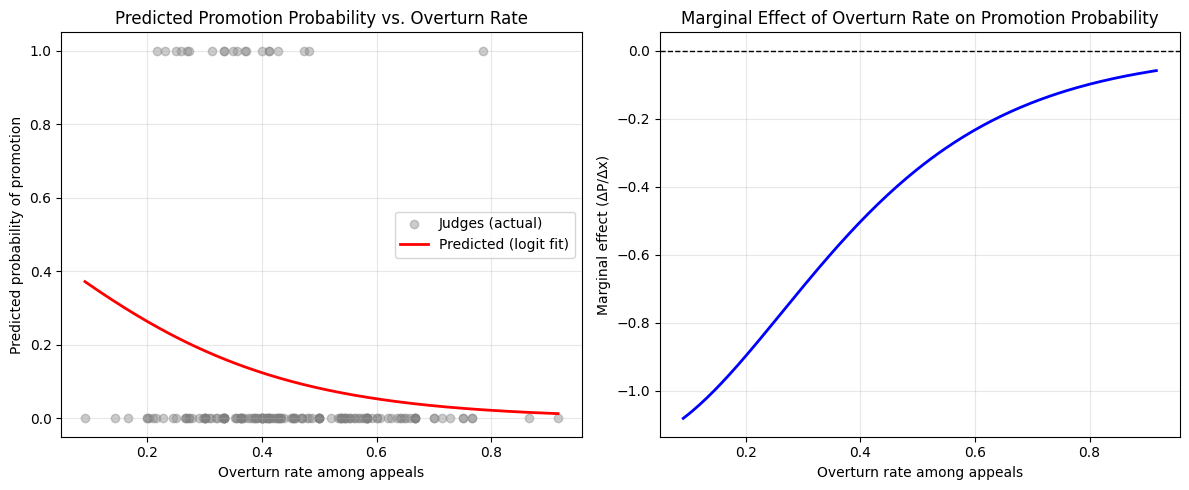

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Use your DataFrame here (with 'is_promoted' and 'overturn_rate_among_appeals')
data = bt10.copy()

# Fit logistic model
y = bt10["is promoted"].astype(int)
X = bt10["overturn_rate_among_appeals"].astype(float)
X = sm.add_constant(X) 
logit_mod = sm.Logit(y, X).fit(disp=False)

# Create smooth range of overturn rates
x_range = np.linspace(data["overturn_rate_among_appeals"].min(),
                      data["overturn_rate_among_appeals"].max(), 200)

# Predicted probabilities
X_pred = sm.add_constant(x_range)
y_pred = logit_mod.predict(X_pred)

# Marginal effects (dy/dx = β1 * p * (1 - p))
b0, b1 = logit_mod.params["const"], logit_mod.params["overturn_rate_among_appeals"]
p = 1 / (1 + np.exp(-(b0 + b1 * x_range)))
marginal_effects = b1 * p * (1 - p)

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Predicted probability of promotion
axes[0].scatter(data["overturn_rate_among_appeals"], data["is promoted"],
                alpha=0.4, label="Judges (actual)", color="gray")
axes[0].plot(x_range, y_pred, color="red", linewidth=2, label="Predicted (logit fit)")
axes[0].set_xlabel("Overturn rate among appeals")
axes[0].set_ylabel("Predicted probability of promotion")
axes[0].set_title("Predicted Promotion Probability vs. Overturn Rate")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2️⃣ Marginal effects (derivative curve)
axes[1].plot(x_range, marginal_effects, color="blue", linewidth=2)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Overturn rate among appeals")
axes[1].set_ylabel("Marginal effect (ΔP/Δx)")
axes[1].set_title("Marginal Effect of Overturn Rate on Promotion Probability")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [61]:
case_results = load_case_results()
case_results.sample(1)

,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level,lower_judge_first,lower_judge_last,custom_id
41172,affirmed,criminal,insufficient evidence,male,other,1.0,low,None,None,100430


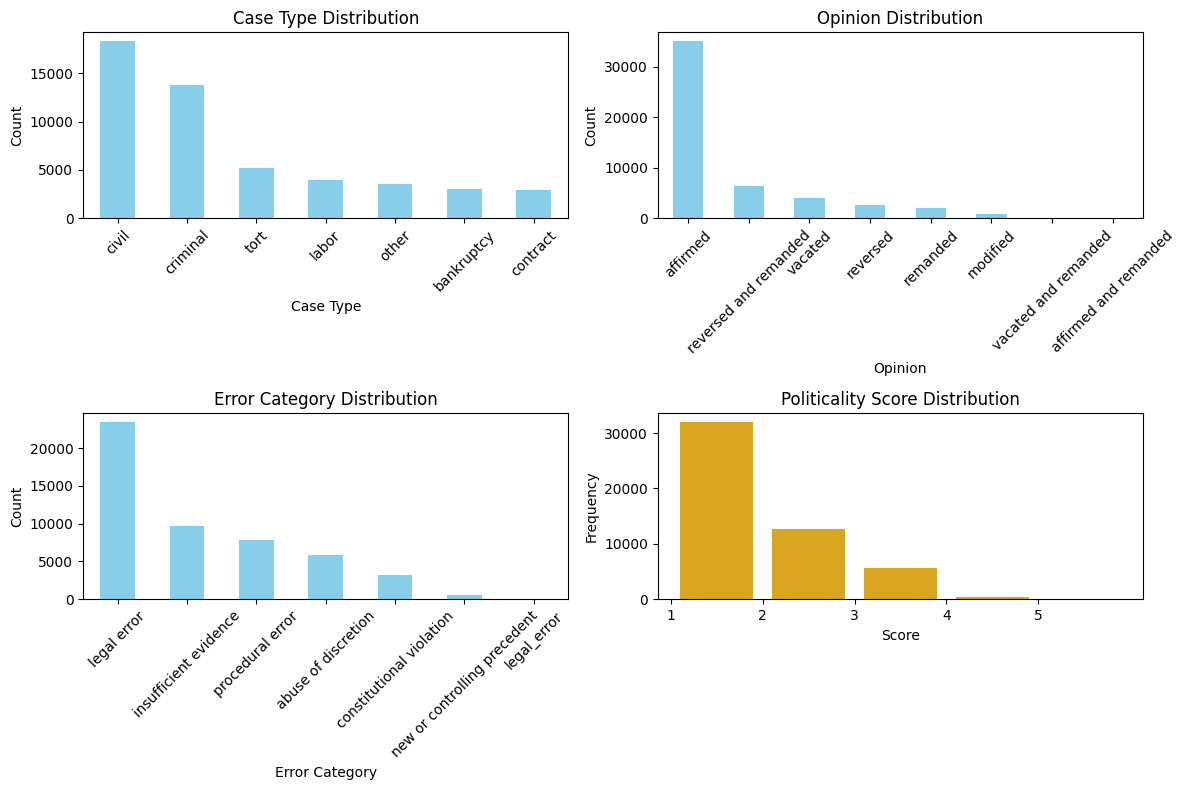

In [62]:
plot_distributions(case_results, ["case_type", "opinion", "error_category", "politicality_score"])

In [401]:
case_results.groupby('case_type').apply(
    lambda group: len(group[group['opinion'] == 'affirmed']) / len(group) * 100
)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/2251497098.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  case_results.groupby('case_type').apply(


case_type
bankruptcy    62.975098
civil         66.692186
contract      59.271978
criminal      75.139726
labor         57.838389
other         82.829978
tort          60.686728
dtype: float64

In [402]:
len(case_results[case_results['opinion']=='affirmed']) / len(case_results) * 100

68.16844893745497

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1331619923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["appealed cases"] = bt10["appealed cases"].astype(int)
/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1331619923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)


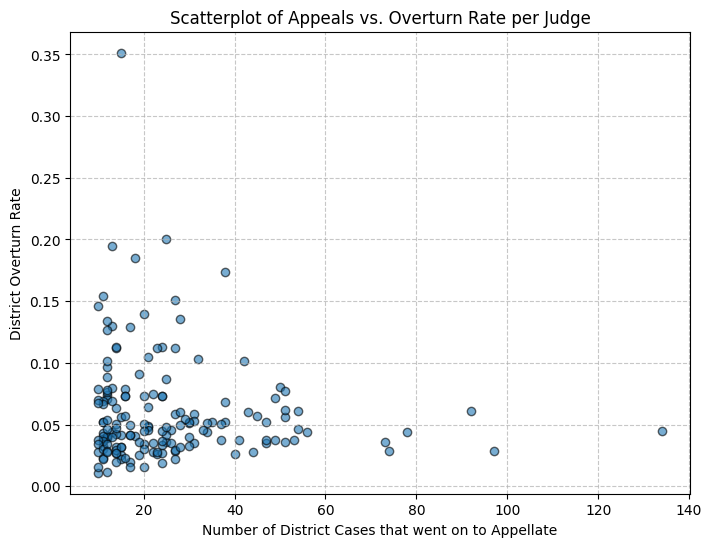

In [403]:
import matplotlib.pyplot as plt

# Example: use your DataFrame "bt10"
# Ensure numeric types
bt10["appealed cases"] = bt10["appealed cases"].astype(int)
bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)

plt.figure(figsize=(8,6))
plt.scatter(
    bt10["appealed cases"], 
    bt10["district_overturn_rate"], 
    alpha=0.6, edgecolor="k"
)

plt.xlabel("Number of District Cases that went on to Appellate")
plt.ylabel("District Overturn Rate")
plt.title("Scatterplot of Appeals vs. Overturn Rate per Judge")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [404]:
import json
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Inputs you already have:
# df: cases DataFrame with index = district case id; columns include is_appellate, opinion_author_id
# pj: judges DataFrame with "judge id" and a column "district_cases_list" (list of district case ids per judge)
# mapping_path: JSON mapping {<appellate_id>: <district_index>}

mapping_path = "results/appellate_matches.json"

# 1) Build the set of *district* case ids that were appealed
with open(mapping_path, "r", encoding="utf-8") as f:
    app_to_dct = json.load(f)

appealed_district_ids = set()
for k, v in app_to_dct.items():
    try:
        appealed_district_ids.add(int(v))
    except Exception:
        continue

# 2) Per judge: count how many of their district cases were appealed (regardless of outcome)
def count_appealed(case_list):
    if not isinstance(case_list, (list, tuple)):
        return 0
    return sum(1 for cid in case_list if cid in appealed_district_ids)

pj = bt10.copy()
pj["appealed_cases"] = pj["appealed cases"]

# 3) Quick dispersion view: mean/median/std/CV and a few quantiles
summary = pj["appealed_cases"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95])
cv = (pj["appealed_cases"].std(ddof=1) / max(summary["mean"], 1e-9))
print("Appealed cases per judge — summary stats")
print(summary)
print(f"Coefficient of Variation (std/mean): {cv:.3f}")

# (Optional) peek at a few extremes
print("\nTop 10 judges by appealed cases:")
print(pj[["judge id","appealed_cases","district cases"]].sort_values("appealed_cases", ascending=False).head(10))

print("\nBottom 10 judges by appealed cases (with at least 1 district case):")
print(pj[pj["district cases"]>0][["judge id","appealed_cases","district cases"]]
      .sort_values("appealed_cases", ascending=True).head(10))

# 4) Are judges getting “about the same” number appealed given exposure?
#    Test: assume a common appeal probability p across judges; compare observed vs expected with Pearson χ².
#    Only include judges with at least 1 district case to avoid division issues.
g = pj[pj["district cases"] > 0].copy()
n = g["district cases"].to_numpy(dtype=float)       # exposures (trials)
obs = g["appealed_cases"].to_numpy(dtype=float)

# Global appeal rate p-hat:
p_hat = obs.sum() / n.sum() if n.sum() > 0 else np.nan
exp = n * p_hat

# Filter out judges whose expected count is ~0 (no power there)
mask = exp > 0
obs2 = obs[mask]
exp2 = exp[mask]
k = obs2.size

if k >= 2 and np.isfinite(p_hat):
    chi2_stat = ((obs2 - exp2)**2 / exp2).sum()
    # degrees of freedom ~ (k - 1) because we estimated a single parameter p_hat
    df_ = max(k - 1, 1)
    p_value = 1 - chi2.cdf(chi2_stat, df_)
    print("\nGoodness-of-fit to a single common appeal rate (binomial with exposure):")
    print(f"- p_hat (overall appeal rate): {p_hat:.4f}")
    print(f"- Pearson χ²: {chi2_stat:.2f} on {df_} df  ->  p = {p_value:.4g}")
    if p_value < 0.05:
        print("⇒ Variation across judges is larger than expected if all shared the same appeal rate.")
    else:
        print("⇒ No strong evidence of heterogeneity; appealed counts look consistent with a common rate.")
else:
    print("\nNot enough data to run the goodness-of-fit test (check exposures).")

# 5) (Optional) Standardized residuals per judge to see who’s high/low relative to exposure
if k >= 2 and np.isfinite(p_hat):
    # Avoid division by zero
    denom = np.sqrt(np.maximum(exp, 1e-12))
    g["std_resid"] = (obs - exp) / denom
    print("\nJudges with largest positive residuals (more appeals than expected given exposure):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=False).head(10))
    print("\nJudges with most negative residuals (fewer appeals than expected):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=True).head(10))

Appealed cases per judge — summary stats
count    167.000000
mean      25.119760
std       17.959728
min       10.000000
10%       11.000000
25%       13.000000
50%       20.000000
75%       30.000000
90%       47.800000
95%       53.700000
max      134.000000
Name: appealed_cases, dtype: float64
Coefficient of Variation (std/mean): 0.715

Top 10 judges by appealed cases:
      judge id  appealed_cases  district cases
1969      1287             134             629
3071      2032              97            1133
1370       896              92             624
950        616              78             590
2267      1484              74             529
2424      1597              73             749
3802      2527              56             709
1184       773              54             388
2678      1763              54             245
3208      2118              53             347

Bottom 10 judges by appealed cases (with at least 1 district case):
      judge id  appealed_cases  distric

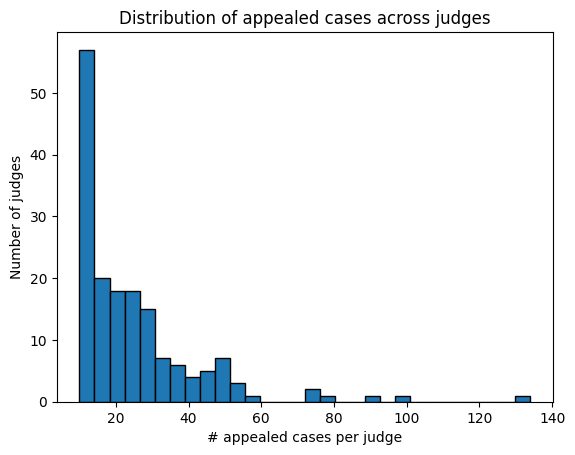

In [405]:
import matplotlib.pyplot as plt

plt.hist(pj["appealed_cases"], bins=30, edgecolor="black")
plt.xlabel("# appealed cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of appealed cases across judges")
plt.show()

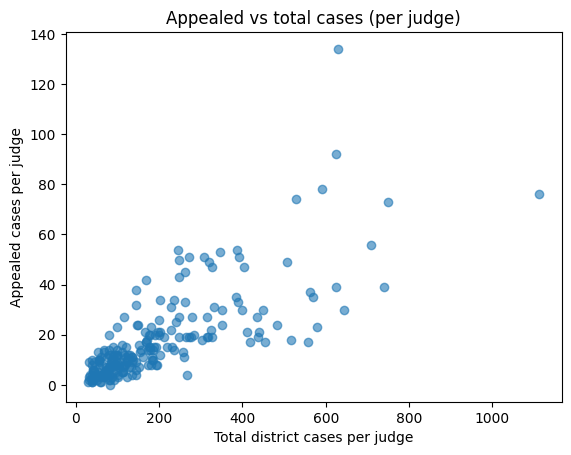

In [160]:
plt.scatter(pj["district cases"], pj["appealed_cases"], alpha=0.6)
plt.xlabel("Total district cases per judge")
plt.ylabel("Appealed cases per judge")
plt.title("Appealed vs total cases (per judge)")
plt.show()

In [123]:
len(judges)

4674

In [ ]:
# def cl_cleaner(cl_data: pd.DataFrame, judges_info: pd.DataFrame) -> pd.DataFrame:
#     out = cl_data.copy()
#     out["district judge"]       = judge_name_to_id(out, judges_info, "last name", text_col="combined_preview")
#     out["district judge id"]    = judge_name_to_id(out, judges_info, "id",        text_col="combined_preview")
#     out["unique_id"]            = "CL_" + out["id"].astype(str)
#     # out.rename(columns={"case_name":"name","combined_preview":"opinion_text"}, inplace=True)
#     cols = ["unique_id","name","combined_preview","docket_number","district judge","district judge id","decision_date"]
#     return out.loc[out["district judge id"].notna(), cols].reset_index(drop=True)

# cl_clean['opinion_text'].sample(1).iloc[0]